# Dakota vs Salesforce Data Clean
## Dakota Clean Up
- Dupe check + removal
- Segment the wire houses

## Match List
- Create a match list between what we had and what we are adding in salesforce
- Fill in all blanks using Dakota
- Make sure state/city is standardized
- Format to salesforce
- Trust Dakota's data over what's already in salesforce
    - Names and spelling here


# Packages

In [74]:
%pip install pandas openpyxl matplotlib 
import pandas as pd
import matplotlib.pyplot as plt
import os
import difflib

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [75]:
print(os.getcwd())

dakota_file_path =  "../data/all_contacts/Dakota_All_Contacts.xlsx"
dakota_df=pd.read_excel(dakota_file_path)

salesforce_file_path=file_path = "../data/all_contacts/Salesforce_dataset.xlsx"
salesforce_df = pd.read_excel(salesforce_file_path)

# dakota_df.head()
salesforce_df.head()

print(f"Total number of account entries: {dakota_df['Account Name'].count()}")

# Make a copy to track changes
original_df = salesforce_df.copy()

# Define standardization function
def standardize_country(country, state):
    if pd.isnull(country):
        country = ''
    country_upper = str(country).strip().upper()
    if country_upper in ['UNITED STATES', 'U.S.', 'USA', 'US']:
        return 'United States'
    if pd.notnull(state) and str(state).strip() != '':
        return 'United States'
    return country

# Apply the function to the cleaned dataset
salesforce_df['Mailing Country'] = salesforce_df.apply(
    lambda row: standardize_country(row['Mailing Country'], row['Mailing State/Province']),
    axis=1)

# Standardize U.S. country names in Dakota dataset
dakota_df['Mailing Country'] = dakota_df.apply(
    lambda row: standardize_country(row.get('Mailing Country'), row.get('Mailing State/Province')),
    axis=1
)



c:\Users\MarkBogorad\OneDrive - Rockefeller Capital Management\MarkB\RCM\data_cleaning
Total number of account entries: 167025


# Dakota Analysis

Number of duplicate emails before removing them: 12822
Total number of unique accounts: 18703
Total number of account entries: 154203


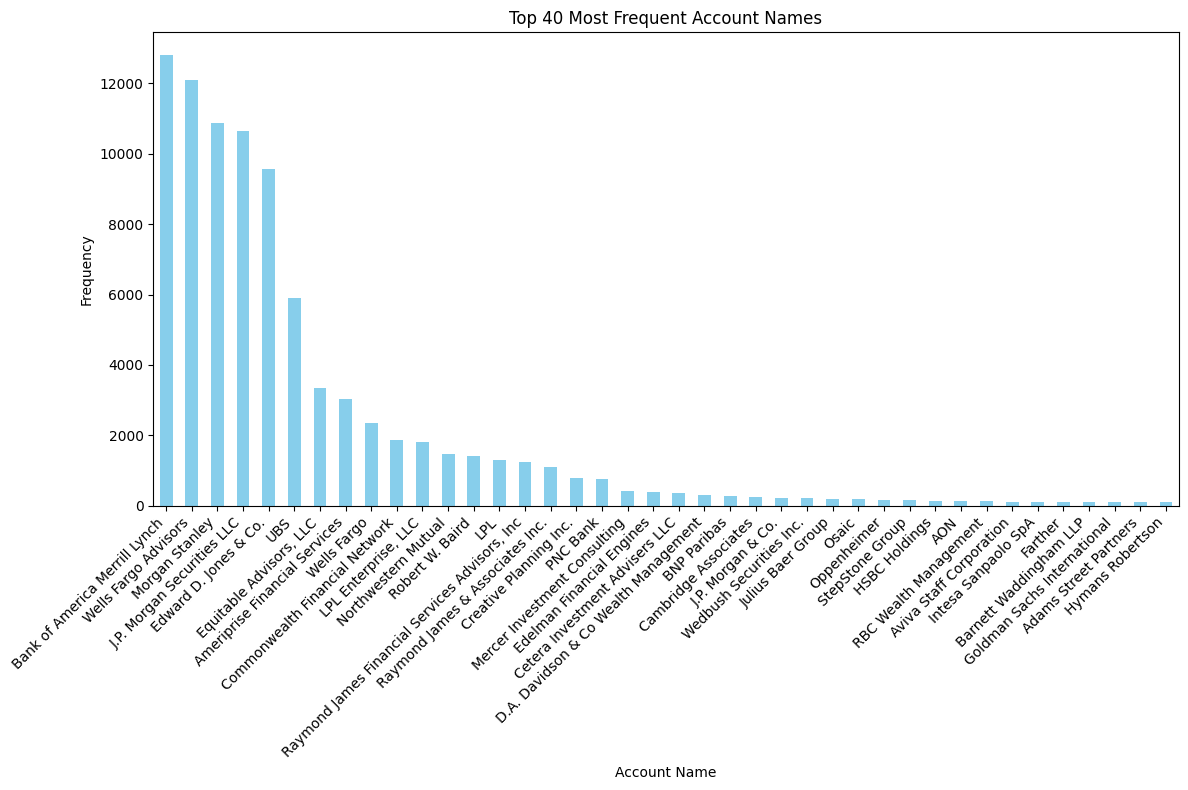

In [76]:
# Count the number of duplicate emails before removing them
num_duplicate_emails_before = dakota_df['Email'].duplicated().sum()
print(f"Number of duplicate emails before removing them: {num_duplicate_emails_before}")

# Remove duplicate rows based on the 'Email' column
dakota_df = dakota_df.drop_duplicates(subset='Email')

# Count unique and total account entries
print(f"Total number of unique accounts: {dakota_df['Account Name'].nunique()}")
print(f"Total number of account entries: {dakota_df['Account Name'].count()}")

# Count the frequency of each unique account name
account_name_counts = dakota_df['Account Name'].value_counts()

# Select the top 40 most frequent accounts
top_40_accounts = account_name_counts.head(40)

# Plot the frequencies of the top 40 accounts
plt.figure(figsize=(12, 8))
top_40_accounts.plot(kind='bar', color='skyblue')
plt.title('Top 40 Most Frequent Account Names')
plt.xlabel('Account Name')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# Wirehouse List

In [77]:
# Define the wirehouse map with additional entries
wirehouse_map = {
    'Bank of America Merrill Lynch': 'Merrill Lynch',
    'Wells Fargo Advisors LLC': 'Wells Fargo',
    'Morgan Stanley & Co.': 'Morgan Stanley',
    'J.P. Morgan Securities LLC': 'J.P. Morgan',
    'UBS Financial Services Inc.': 'UBS',
    'Ameriprise Financial Services Inc.': 'Ameriprise',
    'Raymond James Financial Services Inc.': 'Raymond James',
    'Goldman Sachs & Co. LLC': 'Goldman Sachs',
    'UBS': 'UBS',
    'Morgan Stanley': 'Morgan Stanley',
    'Wells Fargo Advisors': 'Wells Fargo',
    'Wells Fargo': 'Wells Fargo',
    'Ameriprise Financial Services': 'Ameriprise',
    'Goldman Sachs International': 'Goldman Sachs',
    'Raymond James Financial Services Advisors, Inc': 'Raymond James',
    'Raymond James & Associates Inc.': 'Raymond James',
    'J.P. Morgan & Co.': 'J.P. Morgan',
    'BlackRock': 'BlackRock',
    'Edward D. Jones': 'Edward Jones',
    'BlackRock Alternative Investors': 'BlackRock',
    'BlackRock Alternative Investors (BAI)': 'BlackRock'
}

# Normalize account names
dakota_df['Account Name'] = dakota_df['Account Name'].str.strip().str.lower()
normalized_map = {k.lower(): v for k, v in wirehouse_map.items()}

# Fuzzy match function with lower cutoff
def match_wirehouse(name):
    matches = difflib.get_close_matches(name, normalized_map.keys(), n=1, cutoff=0.6) # around 15-20K emails cut out from changing this cutoff from 0.7
    return normalized_map[matches[0]] if matches else None

# Apply fuzzy matching
dakota_df['wirehouse_group'] = dakota_df['Account Name'].apply(match_wirehouse)


# Splitting Wirehouse Datasets from Main

Number of unique emails left: 76460
Number of unique account names left: 17663
Number of duplicate emails: 0


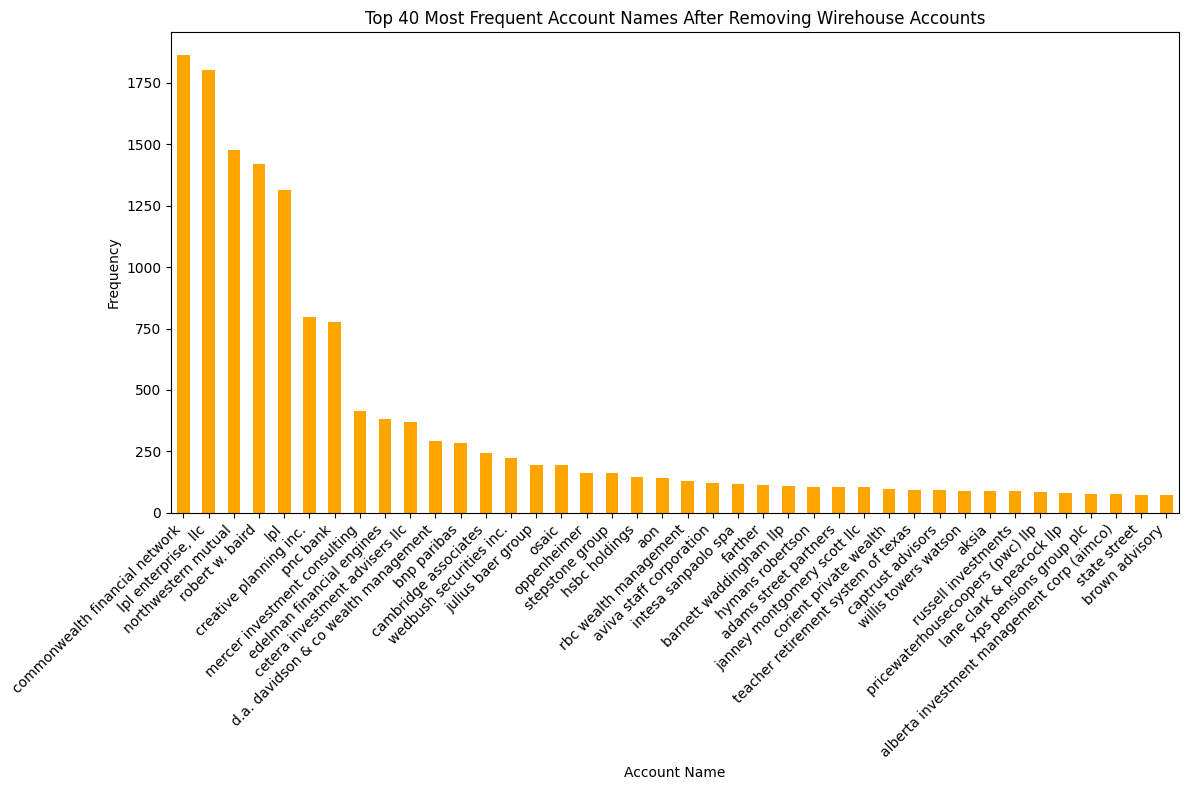

In [78]:
# Segment data
wirehouse_dfs = {
    group: dakota_df[dakota_df['wirehouse_group'] == group].copy()
    for group in dakota_df['wirehouse_group'].dropna().unique()
}
dakota_non_wirehouse_df = dakota_df[dakota_df['wirehouse_group'].isna()].copy()

# Summary stats
num_unique_emails = dakota_non_wirehouse_df['Email'].nunique()
num_unique_accounts = dakota_non_wirehouse_df['Account Name'].nunique()
num_duplicate_emails = dakota_non_wirehouse_df['Email'].duplicated().sum()

print(f"Number of unique emails left: {num_unique_emails}")
print(f"Number of unique account names left: {num_unique_accounts}")
print(f"Number of duplicate emails: {num_duplicate_emails}")

# Plot top 40 remaining accounts
top_40_accounts = dakota_non_wirehouse_df['Account Name'].value_counts().head(40)
plt.figure(figsize=(12, 8))
top_40_accounts.plot(kind='bar', color='orange')
plt.title('Top 40 Most Frequent Account Names After Removing Wirehouse Accounts')
plt.xlabel('Account Name')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



In [79]:
# Normalize company names
dakota_df['Account Name'] = dakota_df['Account Name'].str.strip().str.lower()
normalized_map = {k.lower(): v for k, v in wirehouse_map.items()}

# Fuzzy match function (reuse if already defined)
def match_wirehouse(name):
    matches = difflib.get_close_matches(name, normalized_map.keys(), n=1, cutoff=0.6)
    return normalized_map[matches[0]] if matches else None

# Apply fuzzy matching
dakota_df['wirehouse_group'] = dakota_df['Account Name'].apply(match_wirehouse)

# Count wirehouse firms
wirehouse_counts_dakota = dakota_df['wirehouse_group'].value_counts()

# Add total row
wirehouse_counts_dakota.loc['Total'] = wirehouse_counts_dakota.sum()

# Display result
print("Wirehouse firms count in Dakota:\n", wirehouse_counts_dakota)


Wirehouse firms count in Dakota:
 wirehouse_group
Wells Fargo       19492
Merrill Lynch     12809
Morgan Stanley    10973
J.P. Morgan       10911
Edward Jones       9568
UBS                6593
Ameriprise         3954
Raymond James      2933
Goldman Sachs       272
BlackRock           237
Total             77742
Name: count, dtype: int64


# Salesforce Data Analysis

In [80]:
# General info
print(salesforce_df.info())

# Summary statistics for all columns
print(salesforce_df.describe(include='all'))

# Check for and display duplicate rows
duplicates = salesforce_df[salesforce_df.duplicated()]
print(f"Number of duplicate rows: {len(duplicates)}")

# Drop duplicates if needed
salesforce_df = salesforce_df.drop_duplicates(subset='Email')

# Count missing values per column
missing = salesforce_df.isnull().sum()
print("Missing values per column:\n", missing)

# Top job titles
print("Top Titles:\n", salesforce_df['Title'].value_counts().head(10))

# Top states/provinces
print("Top Mailing States/Provinces:\n", salesforce_df['Mailing State/Province'].value_counts().head(10))

# Top email domains
email_domains = salesforce_df['Email'].dropna().apply(lambda x: x.split('@')[-1])
print("Top Email Domains:\n", email_domains.value_counts().head(10))

# Top company owners
print("Top Company Owners:\n", salesforce_df['Company Owner'].value_counts().head(10))



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48678 entries, 0 to 48677
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Salutation               18 non-null     object
 1   First Name               48565 non-null  object
 2   Last Name                48677 non-null  object
 3   Title                    45616 non-null  object
 4   Company Name             48678 non-null  object
 5   Mailing Street           36937 non-null  object
 6   Mailing City             46832 non-null  object
 7   Mailing State/Province   45583 non-null  object
 8   Mailing Zip/Postal Code  25401 non-null  object
 9   Mailing Country          48678 non-null  object
 10  Phone                    41363 non-null  object
 11  Fax                      15929 non-null  object
 12  Mobile                   5 non-null      object
 13  Email                    38814 non-null  object
 14  Company Owner            48678 non-nul

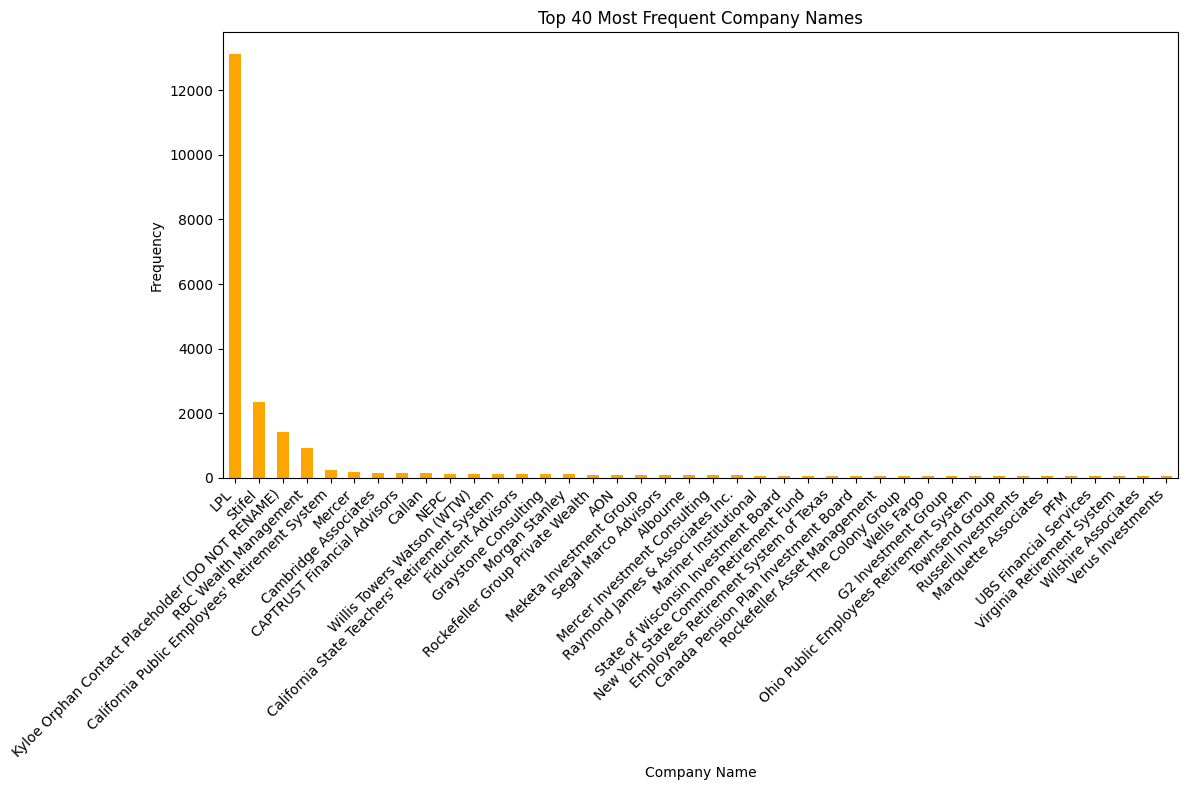

In [81]:
# Get top 40 most frequent company names
top_40_companies = salesforce_df['Company Name'].value_counts().head(40)

# Plot
plt.figure(figsize=(12, 8))
top_40_companies.plot(kind='bar', color='orange')
plt.title('Top 40 Most Frequent Company Names')
plt.xlabel('Company Name')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()




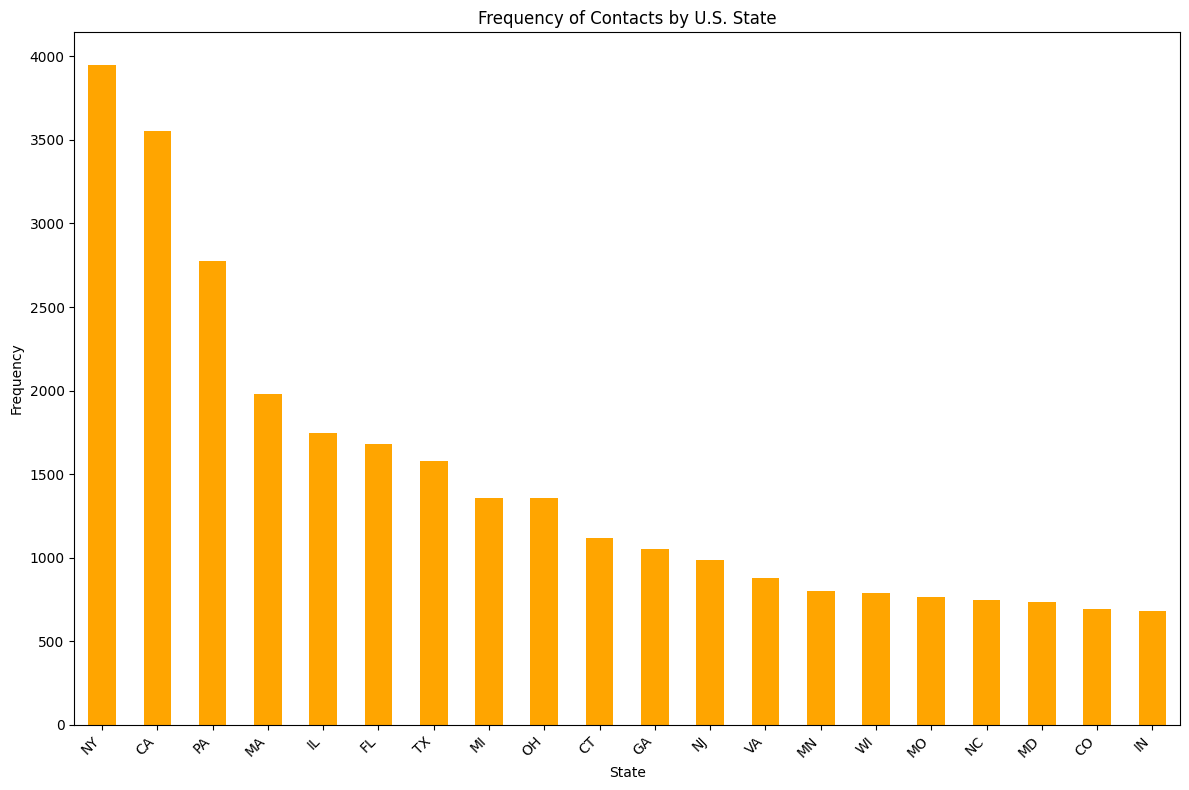

In [82]:
# Top 20 states by contact frequency
state_counts = salesforce_df['Mailing State/Province'].value_counts().head(20)

plt.figure(figsize=(12, 8))
state_counts.plot(kind='bar', color='orange')
plt.title('Frequency of Contacts by U.S. State')
plt.xlabel('State')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



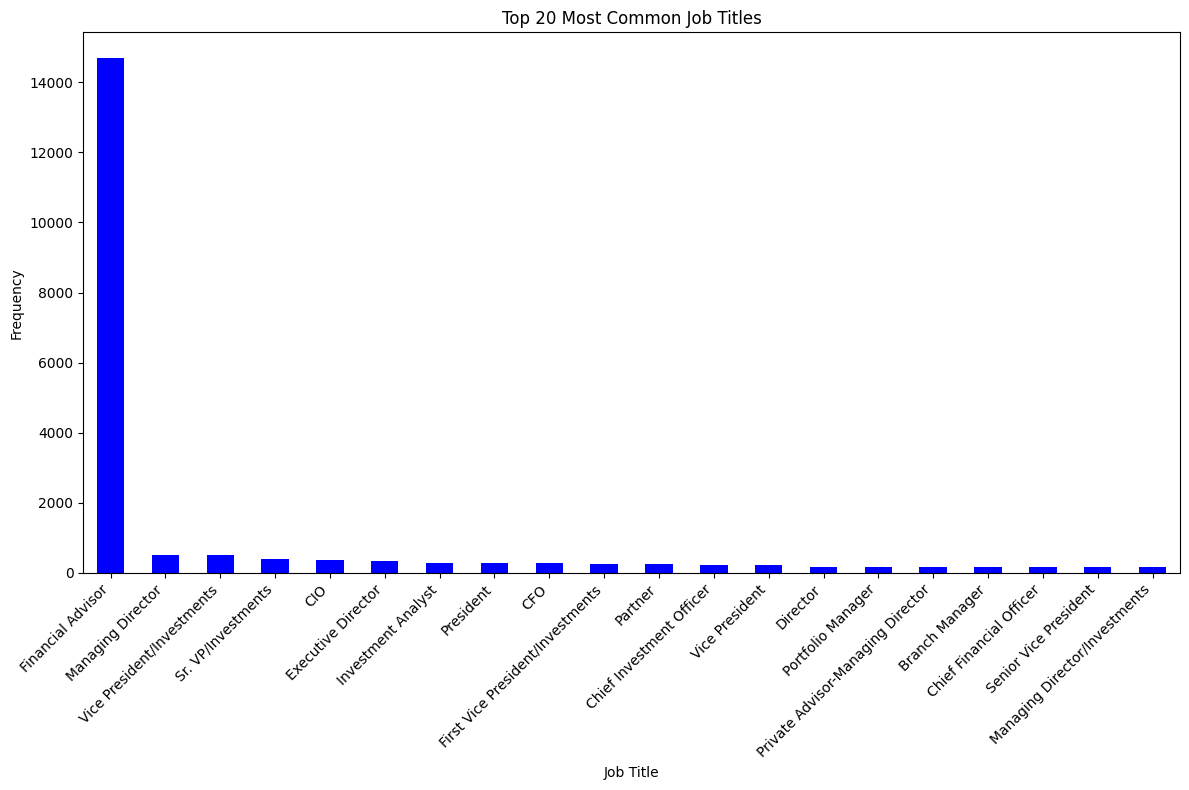

In [83]:
# Get top 20 job titles
top_20_titles = salesforce_df['Title'].value_counts().head(20)

# Plot
plt.figure(figsize=(12, 8))
top_20_titles.plot(kind='bar', color='blue')
plt.title('Top 20 Most Common Job Titles')
plt.xlabel('Job Title')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# Filtering out Wirehouses from Salesforce

In [84]:
# Normalize company names
salesforce_df['Company Name'] = salesforce_df['Company Name'].str.strip().str.lower()
normalized_map = {k.lower(): v for k, v in wirehouse_map.items()}

# Fuzzy match function
def match_wirehouse(name):
    matches = difflib.get_close_matches(name, normalized_map.keys(), n=1, cutoff=0.6)
    return normalized_map[matches[0]] if matches else None

# Apply fuzzy matching
salesforce_df['wirehouse_group'] = salesforce_df['Company Name'].apply(match_wirehouse)

# Count wirehouse firms
wirehouse_counts = salesforce_df['wirehouse_group'].value_counts()

# Add total row
wirehouse_counts.loc['Total'] = wirehouse_counts.sum()

# Display result
print("Wirehouse firms count:\n", wirehouse_counts)

# Create wirehouse and non-wirehouse DataFrames
wirehouse_df = salesforce_df[salesforce_df['wirehouse_group'].notnull()].copy()
salesforce_non_wirehouse_df = salesforce_df[salesforce_df['wirehouse_group'].isnull()].copy()

# Optional: print counts
print(f"Wirehouse contacts: {len(wirehouse_df)}")
print(f"Non-wirehouse contacts: {len(salesforce_non_wirehouse_df)}")

Wirehouse firms count:
 wirehouse_group
Wells Fargo        398
Ameriprise         189
Raymond James      136
UBS                124
Morgan Stanley     117
Merrill Lynch       66
Goldman Sachs       48
J.P. Morgan         45
BlackRock           42
Edward Jones        12
Total             1177
Name: count, dtype: int64
Wirehouse contacts: 1177
Non-wirehouse contacts: 37629


# Non Wirehouse Dakota X Salesforce Match
- Compare and contrast
- Match with Dakota overriding uncertain salesforce bits

--- Dakota Non-Wirehouse Info ---
<class 'pandas.core.frame.DataFrame'>
Index: 76461 entries, 0 to 167024
Data columns (total 22 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   ContactID                    76461 non-null  object
 1   First Name                   76431 non-null  object
 2   Last Name                    76461 non-null  object
 3   Email                        76460 non-null  object
 4   Account ID (Case Safe)       76461 non-null  object
 5   Account Name                 76461 non-null  object
 6   Metro Area: Metro Area Name  76439 non-null  object
 7   Phone                        75640 non-null  object
 8   Title                        76457 non-null  object
 9   Contact Type                 76453 non-null  object
 10  Asset Class Coverage         76438 non-null  object
 11  Mailing Street               75938 non-null  object
 12  Mailing City                 76441 non-null  object
 13  M

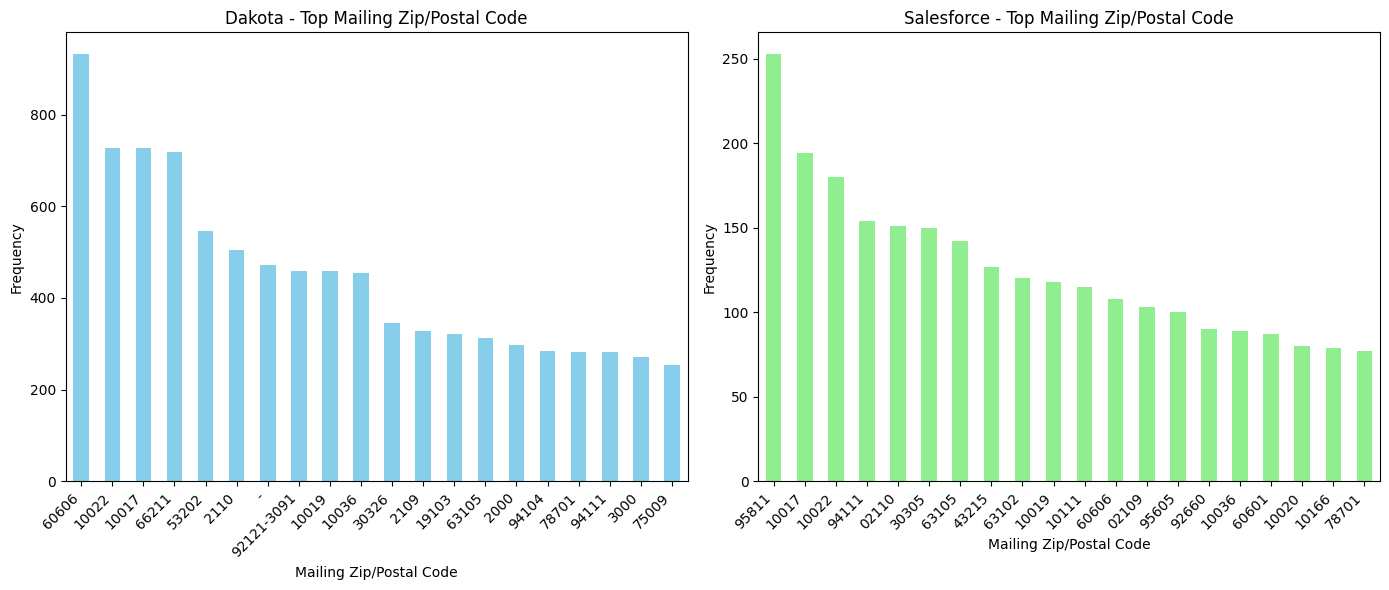

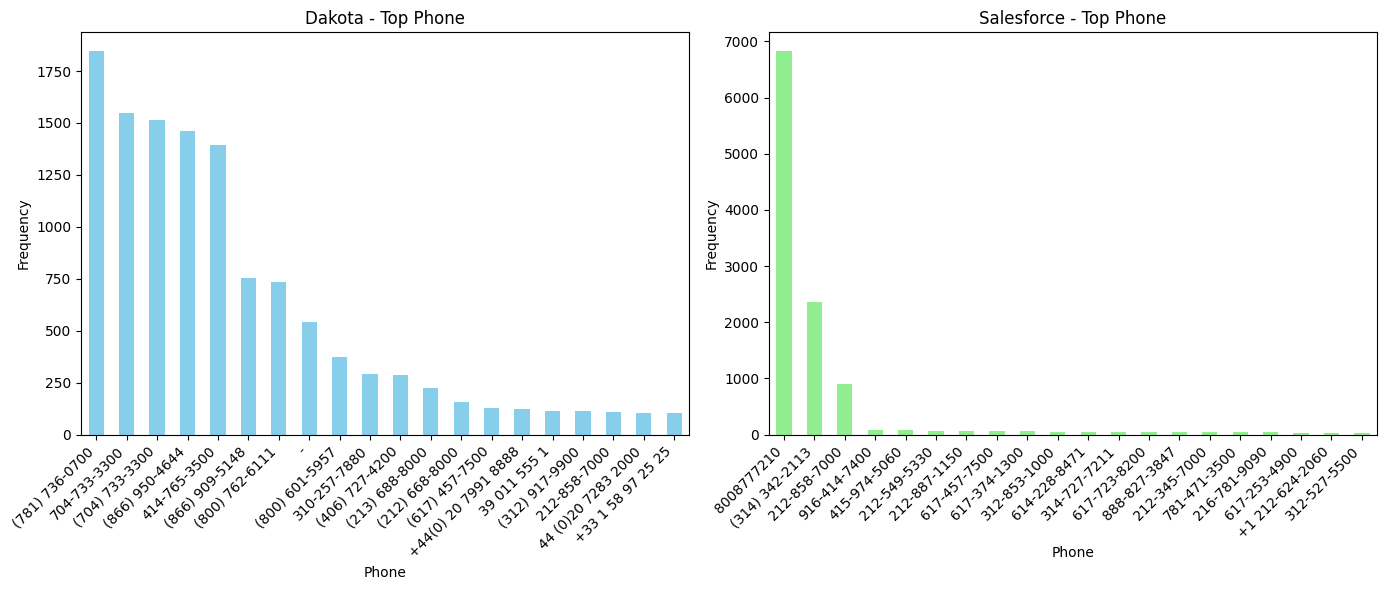

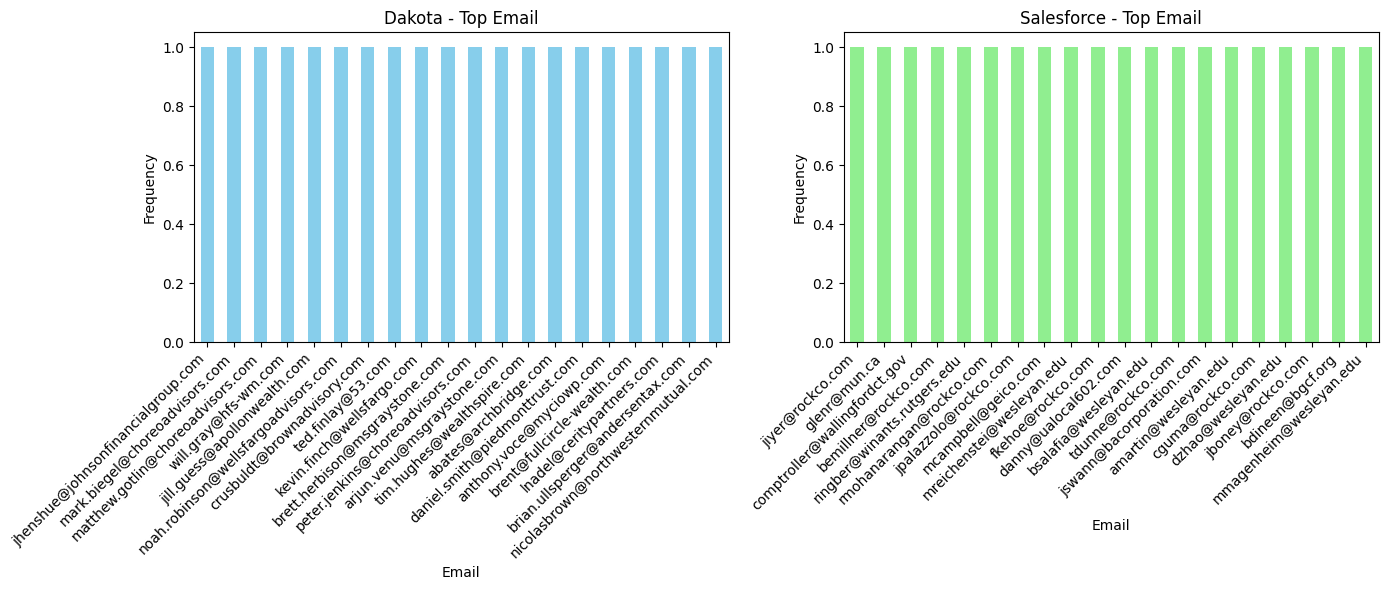

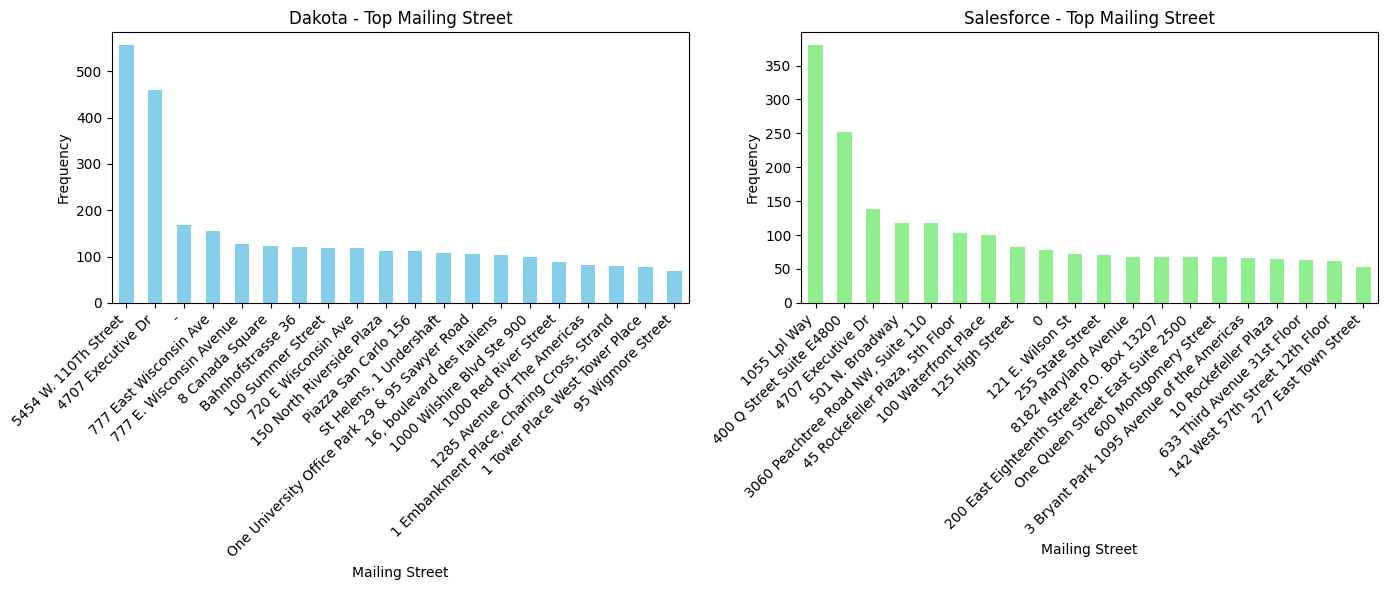

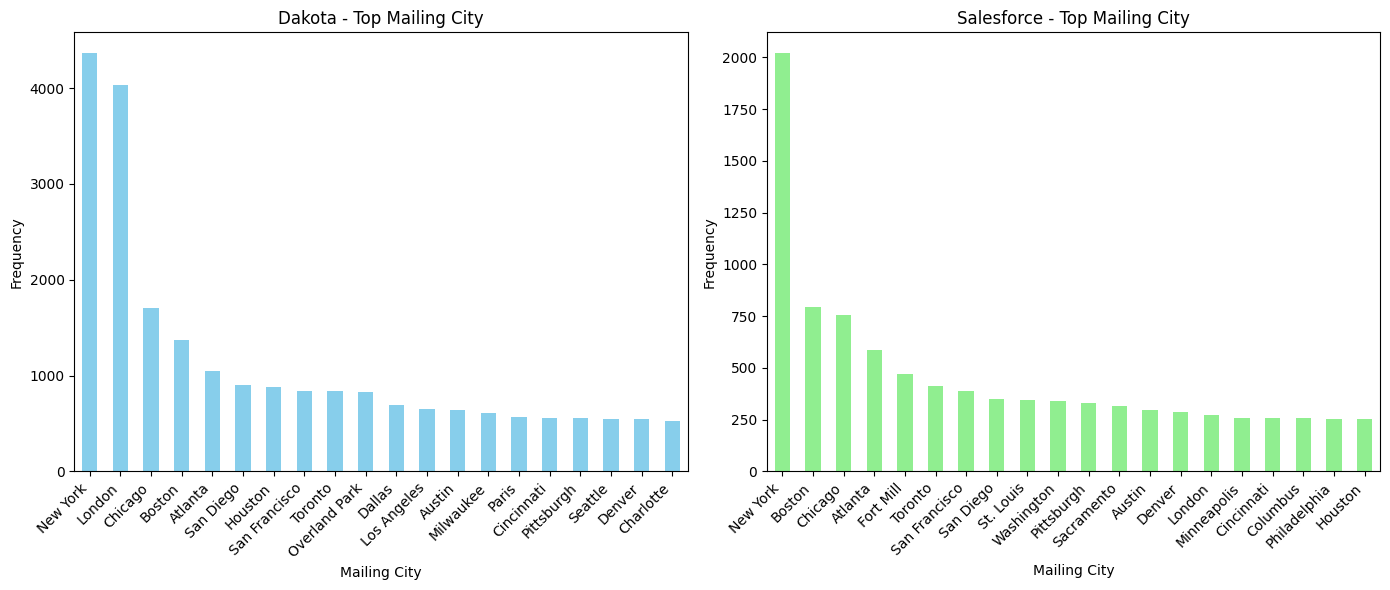

No data to plot for column: wirehouse_group


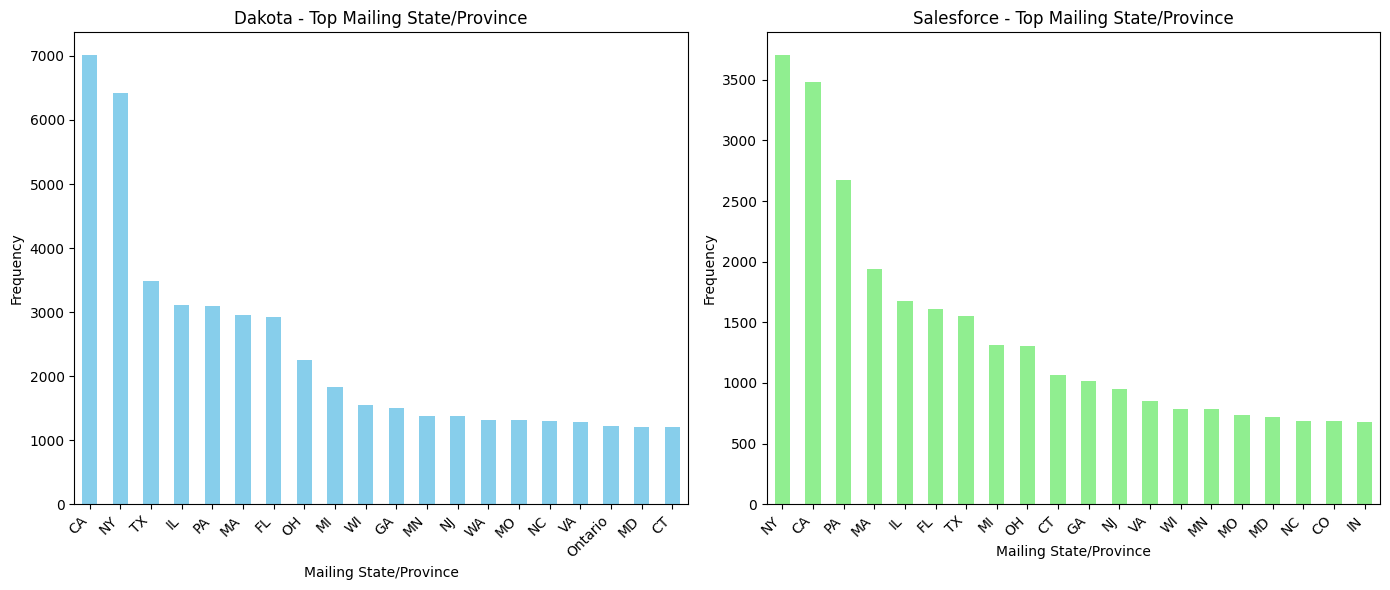

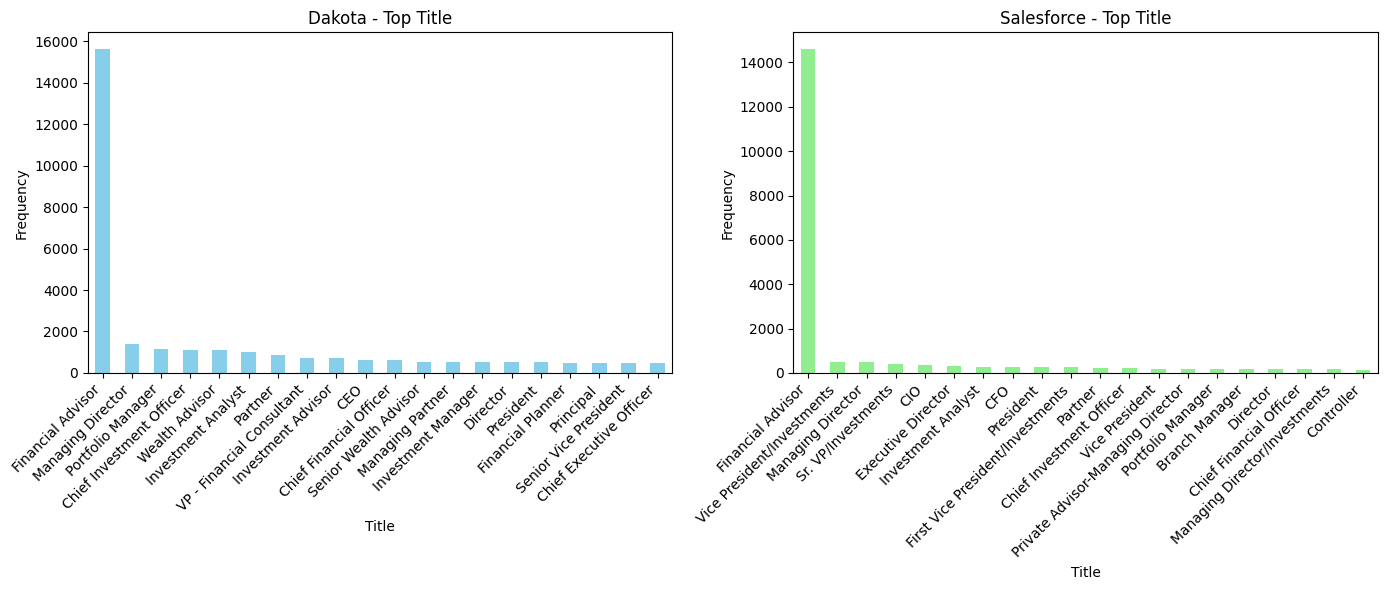

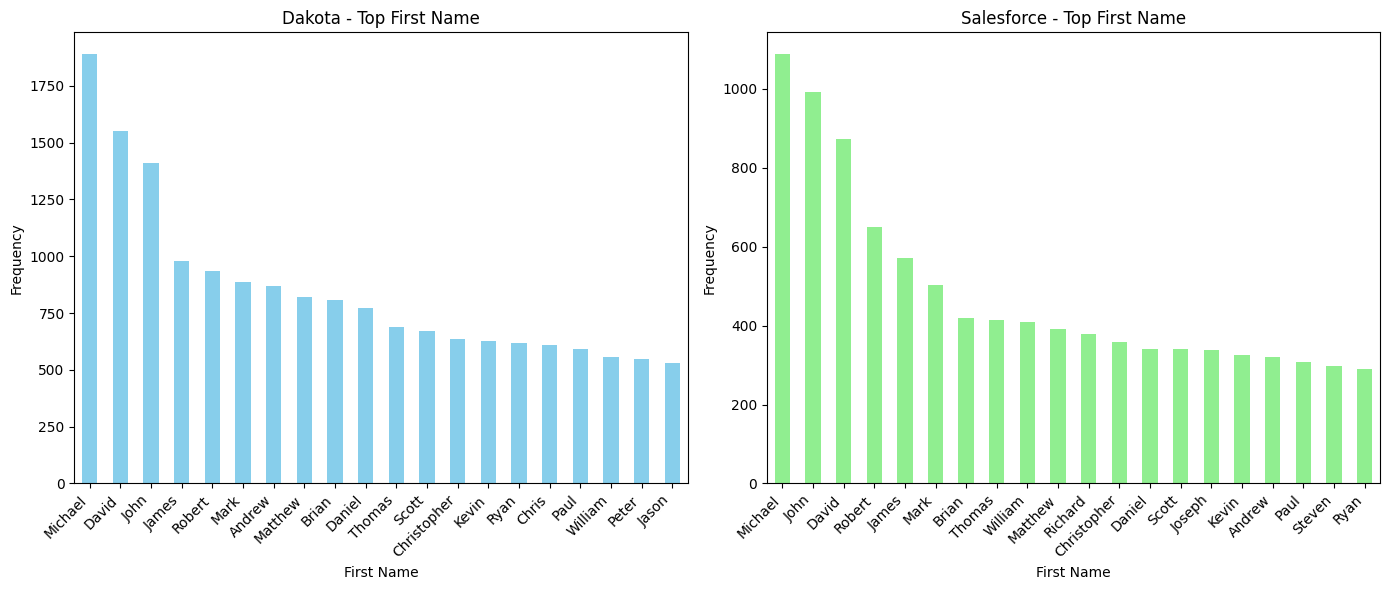

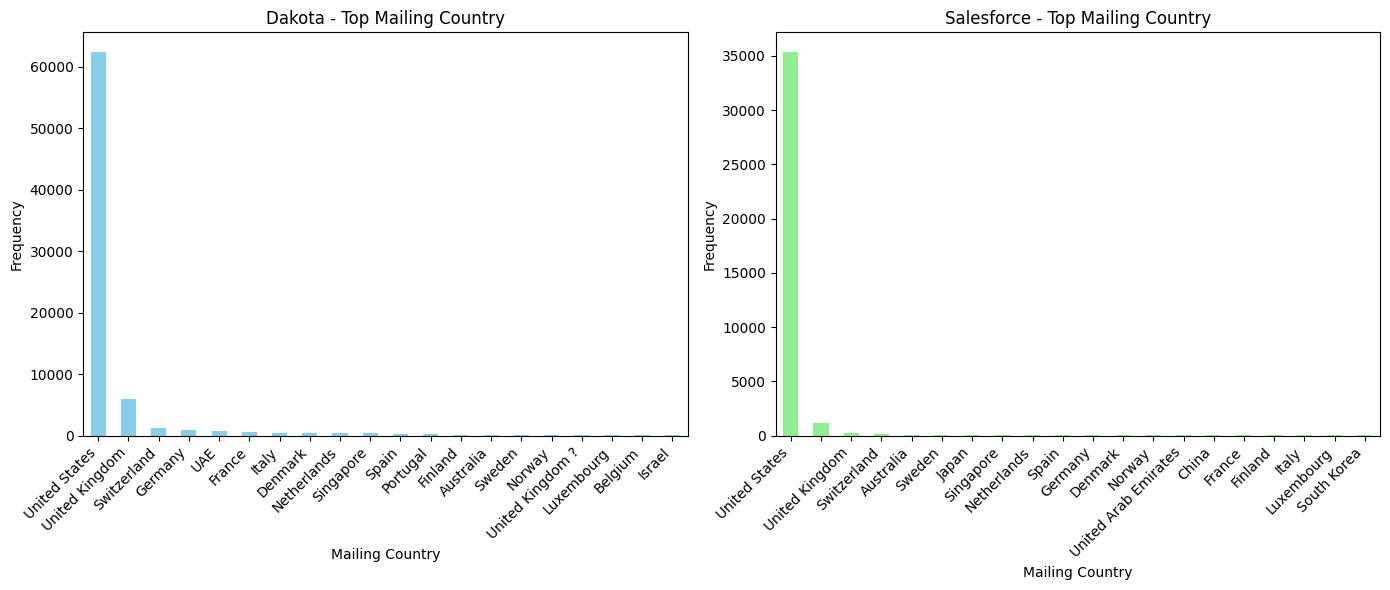

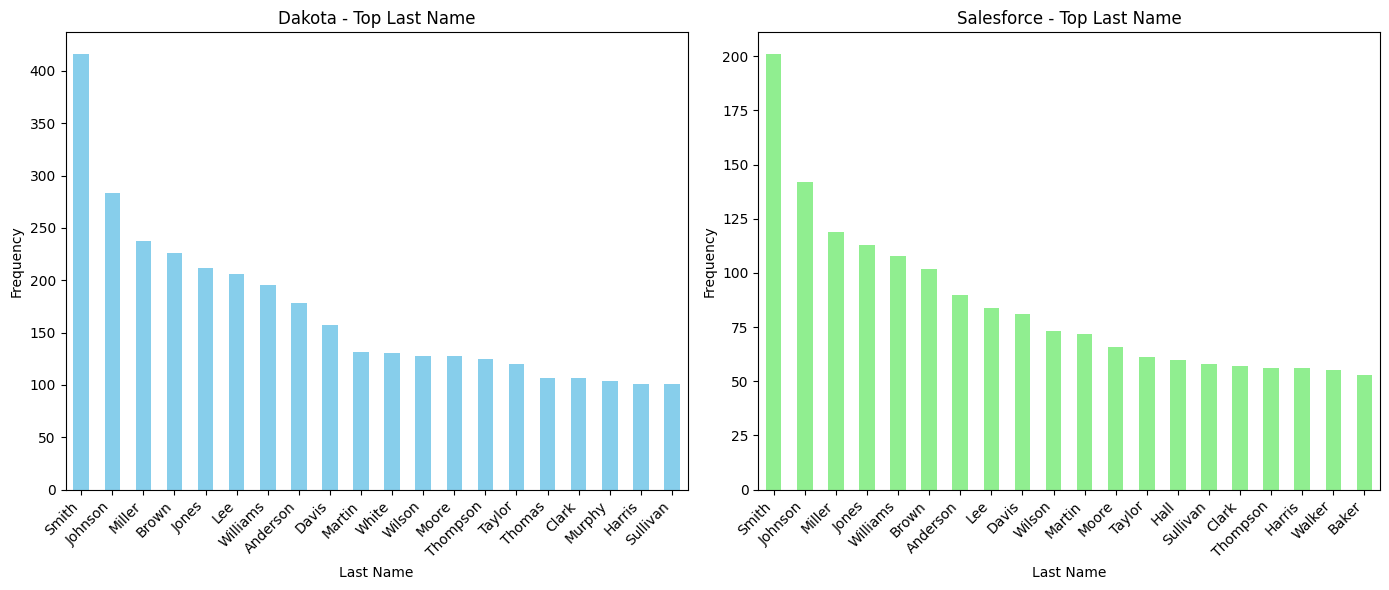

In [85]:
# --- Metadata Comparison ---
def compare_metadata(df1, df2, df1_name, df2_name):
    print(f"--- {df1_name} Info ---")
    print(df1.info())
    print(df1.describe(include='all'))
    print("\n")

    print(f"--- {df2_name} Info ---")
    print(df2.info())
    print(df2.describe(include='all'))
    print("\n")

    # Compare column sets
    df1_cols = set(df1.columns)
    df2_cols = set(df2.columns)

    print(f"Columns in {df1_name} but not in {df2_name}: {df1_cols - df2_cols}")
    print(f"Columns in {df2_name} but not in {df1_name}: {df2_cols - df1_cols}")
    print(f"Common columns: {df1_cols & df2_cols}")

def plot_column_distribution(df1, df2, column, df1_name, df2_name):
    df1_value_counts = df1[column].value_counts().head(20)
    df2_value_counts = df2[column].value_counts().head(20)

    if df1_value_counts.empty and df2_value_counts.empty:
        print(f"No data to plot for column: {column}")
        return

    plt.figure(figsize=(14, 6))

    if not df1_value_counts.empty:
        plt.subplot(1, 2, 1)
        df1_value_counts.plot(kind='bar', color='skyblue')
        plt.title(f'{df1_name} - Top {column}')
        plt.xticks(rotation=45, ha='right')
        plt.ylabel('Frequency')

    if not df2_value_counts.empty:
        plt.subplot(1, 2, 2)
        df2_value_counts.plot(kind='bar', color='lightgreen')
        plt.title(f'{df2_name} - Top {column}')
        plt.xticks(rotation=45, ha='right')
        plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

# Example usage:
compare_metadata(dakota_non_wirehouse_df, salesforce_non_wirehouse_df, "Dakota Non-Wirehouse", "Salesforce Non-Wirehouse")

# Plot comparisons for shared columns
shared_columns = set(dakota_non_wirehouse_df.columns) & set(salesforce_non_wirehouse_df.columns)
for col in shared_columns:
    if dakota_non_wirehouse_df[col].dtype == 'object':
        plot_column_distribution(dakota_non_wirehouse_df, salesforce_non_wirehouse_df, col, "Dakota", "Salesforce")


# Field Matching
Dakota
 0   ContactID                    76461 non-null  object - not in salesforce        
 1   First Name                   76431 non-null  object - First Name
 2   Last Name                    76461 non-null  object - Last Name
 3   Email                        76460 non-null  object - Email
 4   Account ID (Case Safe)       76461 non-null  object - not in salesforce
 5   Account Name                 76461 non-null  object - Company Name
 6   Metro Area: Metro Area Name  76439 non-null  object - not in salesforce but derivable from city
 7   Phone                        75640 non-null  object - Phone
 8   Title                        76457 non-null  object - Title
 9   Contact Type                 76453 non-null  object - very similar to title
 10  Asset Class Coverage         76438 non-null  object - unique Dakota
 11  Mailing Street               75938 non-null  object - same 
 12  Mailing City                 76441 non-null  object - same 
 13  Mailing State/Province       62511 non-null  object - same 
 14  Mailing Zip/Postal Code      75830 non-null  object - same 
 15  Mailing Country              76456 non-null  object - same 
 16  Biography                    28665 non-null  object - text about their background
 17  CRD #                        30611 non-null  object - not in salesforce
 18  Last Modified DateTime       76461 non-null  object - not needed
 19  Created DateTime             76461 non-null  object - not needed
 20  Unnamed: 20                  1 non-null      object - N/A
 21  wirehouse_group              0 non-null      object - N/A

Salesforce
---  ------                   --------------  ----- 
 0   Salutation               3 non-null      object - Not in Dakota and many empty 
 1   First Name               37523 non-null  object - same
 2   Last Name                37629 non-null  object - same
 3   Title                    35354 non-null  object - same
 4   Company Name             37629 non-null  object - Account Name
 5   Mailing Street           27010 non-null  object - same 
 6   Mailing City             36202 non-null  object - same 
 7   Mailing State/Province   35350 non-null  object - same 
 8   Mailing Zip/Postal Code  15551 non-null  object - same 
 9   Mailing Country          36343 non-null  object - same 
 10  Phone                    31198 non-null  object - same
 11  Fax                      10095 non-null  object - not in Dakota
 12  Mobile                   5 non-null      object - not in Dakota
 13  Email                    37628 non-null  object - same
 14  Company Owner            37629 non-null  object - if not existing, make it Rockefeller Asset Management? 
 15  wirehouse_group          0 non-null      object - N/A 

 New DB
---  ------                   --------------  ----- 
0 First Name
1 Last Name
2 Title
3 Company Name (merge with account name)
4 Email
5 Mailing Street
6 Mailing City
7 Mailing State/Province
8 Mailing Zip/Postal Code
9 Mailing Country 
10 Phone
11 Company Owner

In [86]:
# Standardize emails
salesforce_non_wirehouse_df['Email'] = salesforce_non_wirehouse_df['Email'].str.strip().str.lower()
dakota_non_wirehouse_df['Email'] = dakota_non_wirehouse_df['Email'].str.strip().str.lower()

# Rename 'Account Name' in Dakota to 'Company Name' to standardize BEFORE merging
if 'Account Name' in dakota_non_wirehouse_df.columns:
    dakota_non_wirehouse_df = dakota_non_wirehouse_df.rename(columns={'Account Name': 'Company Name'})

# Drop rows with missing emails
salesforce_non_wirehouse_df = salesforce_non_wirehouse_df.dropna(subset=['Email'])
dakota_non_wirehouse_df = dakota_non_wirehouse_df.dropna(subset=['Email'])

# Check how many NaNs existed before the merge
print("🔍 Missing values in Salesforce before merge:")
print(salesforce_non_wirehouse_df.isna().sum())

print("🔍 Missing values in Dakota before merge:")
print(dakota_non_wirehouse_df.isna().sum())

# Count and show duplicates before dropping
print("📌 Salesforce duplicate emails before dropping:",
      salesforce_non_wirehouse_df.duplicated(subset='Email').sum())
print("📌 Dakota duplicate emails before dropping:",
      dakota_non_wirehouse_df.duplicated(subset='Email').sum())

# Drop duplicate emails
salesforce_non_wirehouse_df = salesforce_non_wirehouse_df.drop_duplicates(subset='Email')
dakota_non_wirehouse_df = dakota_non_wirehouse_df.drop_duplicates(subset='Email')

# Merge datasets on Email
merged = pd.merge(
    salesforce_non_wirehouse_df,
    dakota_non_wirehouse_df,
    on='Email',
    how='outer',
    suffixes=('_sf', '_dk')
)

# Check how many NaNs exist after the merge
print("🔍 Missing values in merged dataset:")
print(merged.isna().sum())

# Override Salesforce fields with Dakota where available
for col in ['First Name', 'Last Name', 'Title', 'Mailing Street', 'Mailing City',
            'Mailing State/Province', 'Mailing Zip/Postal Code', 'Mailing Country', 'Phone']:
    col_sf = f"{col}_sf"
    col_dk = f"{col}_dk"
    merged[col] = merged.get(col_dk, pd.Series(index=merged.index)).combine_first(
                  merged.get(col_sf, pd.Series(index=merged.index)))

merged['Company Name'] = merged.get('Company Name_dk', pd.Series(index=merged.index)).combine_first(
                         merged.get('Company Name_sf', pd.Series(index=merged.index)))

# Capitalize company names
merged['Company Name'] = merged['Company Name'].str.title()


# Use Salesforce's Company Owner if available
merged['Company Owner'] = merged.get('Company Owner_sf', pd.Series(index=merged.index))

# Analytics
total_contacts = len(merged)
new_contacts = merged['Email'].isin(dakota_non_wirehouse_df['Email']) & ~merged['Email'].isin(salesforce_non_wirehouse_df['Email'])
num_new_contacts = new_contacts.sum()
coverage_pct = 100 * (1 - num_new_contacts / len(dakota_non_wirehouse_df))

print(f"📊 Total contacts after merge: {total_contacts}")
print(f"🆕 New contacts acquired from Dakota: {num_new_contacts}")
print(f"✅ Dakota contacts already covered: {coverage_pct:.2f}%")

# Final DataFrame
final_columns = ['First Name', 'Last Name', 'Title', 'Company Name', 'Email',
                 'Mailing Street', 'Mailing City', 'Mailing State/Province',
                 'Mailing Zip/Postal Code', 'Mailing Country', 'Phone', 'Company Owner']
final_df = merged[final_columns]

# Preview
print(final_df.head())


🔍 Missing values in Salesforce before merge:
Salutation                 37625
First Name                   106
Last Name                      0
Title                       2275
Company Name                   0
Mailing Street             10619
Mailing City                1427
Mailing State/Province      2279
Mailing Zip/Postal Code    22078
Mailing Country                0
Phone                       6431
Fax                        27533
Mobile                     37623
Email                          0
Company Owner                  0
wirehouse_group            37628
dtype: int64
🔍 Missing values in Dakota before merge:
ContactID                          0
First Name                        30
Last Name                          0
Email                              0
Account ID (Case Safe)             0
Company Name                       0
Metro Area: Metro Area Name       22
Phone                            821
Title                              4
Contact Type                       8
Ass

# Dakota Owner Mapping + Off State

In [87]:
# Define state → team member
state_team_map = {
    'AL': 'AG', 'AK': 'Rockefeller Asset Management', 'AZ': 'KH', 'AR': 'Rockefeller Asset Management',
    'CA': 'AP', 'CO': 'KH', 'CT': 'Rockefeller Asset Management', 'DE': 'KH', 'FL': 'Rockefeller Asset Management',
    'GA': 'AP', 'HI': 'Rockefeller Asset Management', 'ID': 'Rockefeller Asset Management', 'IL': 'MJ',
    'IN': 'KH', 'IA': 'Rockefeller Asset Management', 'KS': 'Rockefeller Asset Management', 'KY': 'AG',
    'LA': 'Rockefeller Asset Management', 'ME': 'Rockefeller Asset Management', 'MD': 'KH', 'MA': 'AP',
    'MI': 'KH', 'MN': 'Rockefeller Asset Management', 'MS': 'Rockefeller Asset Management', 'MO': 'AG',
    'MT': 'Rockefeller Asset Management', 'NE': 'Rockefeller Asset Management', 'NV': 'Rockefeller Asset Management',
    'NH': 'Rockefeller Asset Management', 'NJ': 'KH', 'NM': 'KH', 'NY': 'AG', 'NC': 'AG', 'ND': 'Rockefeller Asset Management',
    'OH': 'KH', 'OK': 'Rockefeller Asset Management', 'OR': 'Rockefeller Asset Management', 'PA': 'KH',
    'RI': 'Rockefeller Asset Management', 'SC': 'AG', 'SD': 'Rockefeller Asset Management', 'TN': 'AG',
    'TX': 'MJ', 'UT': 'KH', 'VT': 'Rockefeller Asset Management', 'VA': 'KH', 'WA': 'Rockefeller Asset Management',
    'WV': 'Rockefeller Asset Management', 'WI': 'MJ', 'WY': 'Rockefeller Asset Management', 'DC': 'KH'
}

# Define team member → OwnerID
team_ownerID_map = {
    'AG': '005a600000177CHAAY',
    'Rockefeller Asset Management': '005a6000005CXtNAAW',
    'KH': '005a6000000c1j8AAA',
    'AP': '005a6000000c1jDAAQ',
    'MJ': '005a60000043nujAAA'
}

# Fill missing Company Owner based on state
final_df['Company Owner'] = final_df.apply(
    lambda row: state_team_map.get(row['Mailing State/Province'], row['Company Owner'])
    if pd.isna(row['Company Owner']) else row['Company Owner'],
    axis=1
)

# Add OwnerID based on Company Owner
final_df['OwnerID'] = final_df['Company Owner'].map(team_ownerID_map)

# Preview
print(final_df[['Company Name', 'Mailing State/Province', 'Company Owner', 'OwnerID']].head())


                           Company Name Mailing State/Province Company Owner  \
0          Korea Investment Corporation                    NaN           NaN   
1                 Nagle Wealth Partners                    NaN           NaN   
2  Electrical Workers, Ibew, Local #369                     KY            AG   
3                 Nagle Wealth Partners                    NaN           NaN   
4                 Nagle Wealth Partners                    NaN           NaN   

              OwnerID  
0                 NaN  
1                 NaN  
2  005a600000177CHAAY  
3                 NaN  
4                 NaN  


C:\Users\MarkBogorad\AppData\Local\Temp\ipykernel_24972\3318487546.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['Company Owner'] = final_df.apply(
C:\Users\MarkBogorad\AppData\Local\Temp\ipykernel_24972\3318487546.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['OwnerID'] = final_df['Company Owner'].map(team_ownerID_map)


In [88]:
# Export final_df to Excel
final_df.to_excel("../data/all_contacts/New_Salesforce_Merge.xlsx", index=False)


In [89]:
# Map team member codes back to full names
team_member_name_map = {
    'AG': 'Austin S. Gardner',
    'KH': 'Katherine H.',
    'AP': 'Alex T. Petrone',
    'MJ': 'Mark Juelis',
    'Rockefeller Asset Management': 'Rockefeller Asset Management'
}

# Replace Company Owner codes with full names
final_df['Company Owner'] = final_df['Company Owner'].map(team_member_name_map).fillna(final_df['Company Owner'])

# Export non-U.S.-based contacts to Excel
non_us_df = final_df[final_df['Mailing Country'].str.strip().str.lower() != 'united states']
non_us_df.to_excel("../data/all_contacts/Non_US_Contacts.xlsx", index=False)


C:\Users\MarkBogorad\AppData\Local\Temp\ipykernel_24972\1100030799.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['Company Owner'] = final_df['Company Owner'].map(team_member_name_map).fillna(final_df['Company Owner'])
